# Game, Clock, Guess
### Predicting Tennis Match Length Based on Player Rank Difference

By Group 29 of section 007

<img src="https://www.atptour.com/-/media/images/news/2022/11/24/21/58/alcaraz-sinner-best-of-2022-grand-slam-matches.jpg"/> 

## Introduction

In tennis, a unique aspect of the game is the duration of the matches. The average men’s tennis matches last between 1.5 to 5 hours. The unpredictability within the sport allows for what was expected to be a quick match to suddenly become lengthy. The expectancy that one has, comes from the tennis players’ rankings. For professional men’s tennis, there’s the Association of Tennis Professionals (ATP): a point system based on the tennis season. The points given depend on the tournament’s difficulty. Tournaments known as “Grand Slams” are given more points compared to tournaments like ATP Tour Masters. A player gains more points when they win. There’s a correlation between tennis player rankings and the length of the tennis match, as one may believe when there’s a greater rank difference between players, the tennis match length is shorter - hence why earlier tournament rounds have shorter match length averages. It’s important to understand the correlation to better manage the tournament regarding the match scheduling. One could ask: based on the difference in rank between the winner and loser of a tennis match, and we predict the length of a game? This correlation also helps within a player’s performance analysis to see who and when a player dominates throughout their matches - a statistic for coaches, players, and fans to have a deeper understanding of the game dynamics. In order to display this correlation, the dataset used displays the Men’s ATP tennis matches through 2017 - 2019, specifically looking at the winner and loser ranks, rank differences, and match length for each match within each tournament. This dataset allows us to visualize the correlation between tennis rankings and match lengths. 

## Methods

*Insert paragraph*
- explain that we're going to try to do a regression model
- blablabla
- First, we have to read and organize the data blabla

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Wrangling and Cleaning the Data

In [3]:
#reading the dataset
game <- read_csv("game_results.csv")

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [65]:
set.seed(2020)
#wrangling and summarizing the data

#selected and created the necessary columns and arranged by descending rank difference while removing hour and point_diff rows with NA values
#calculated the absolute ELO (point) difference between winners and losers to obtain point_diff
transformed_game <- select(game, winner_rank_points, loser_rank_points, minutes, best_of) |>
                    filter(best_of == 3) |> 
                    mutate(hours = minutes/60, point_diff = abs(winner_rank_points - loser_rank_points)) |>
                    arrange(desc(hours)) |>
                    slice(-1) |>
                    drop_na(hours, point_diff)
transformed_game
#used slice(-1) because the longest game in the original dataset was 987 minutes/16.45 hours, but the longest record is only 11 hours and 5 minutes
#this match was also supposedly in 2010, but this dataset consists of only matches from 2017-2019
#even if it were a real game, it's too much of an outlier to be used in the actual dataset and messes with the analysis

#splitting the transformed dataset into training and testing data
game_split <- initial_split(transformed_game, prop = 0.60, strata = minutes)
game_training <- training(game_split)
game_testing <- testing(game_split)

winner_rank_points,loser_rank_points,minutes,best_of,hours,point_diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1295,588,289,3,4.816667,707
495,343,219,3,3.650000,152
954,876,216,3,3.600000,78
⋮,⋮,⋮,⋮,⋮,⋮
4400,968,12,3,0.2000000,3432
2306,816,11,3,0.1833333,1490
1127,2825,8,3,0.1333333,1698


### Table 1: All games organized in order of game length
This figure showcases all the data necessary to perform the data analysis

#### *insert paragraph explaining the process of cleaning the data*

IMPORTANT THINGS TO MENTION
* How we decided which which columns were necessary (and maybe explain what each part is)
* Maybe note that points coincide with rank? (not sure abt this)
* How we calculated point difference
* Note that we limited the data to matches that are only best of 3 because matches that are best of 5 or longer will most likely be longer and interfere with the analysis
_______________
* We removed one sample that said a game was 16 hours because it was too much of an outlier and messed with the accuracy of the analysis
* The next longest game was only close to 5 hours in comparison
* That game might not even be real (or there was an error in the data collection) because google says that the longest match in history was 11 hours from a game in 2010
_______________
* Finally, we split the data into training and testing sets


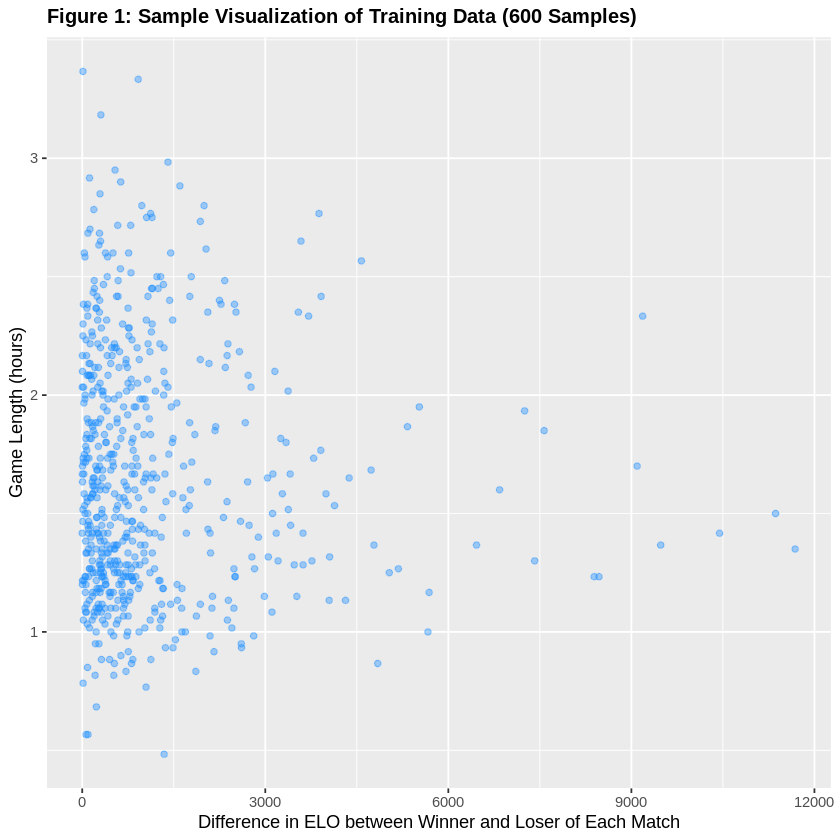

In [73]:
set.seed(2020)
#selecting 600 random samples out of the thousands or so present in the training set
#this helps declutter the dataset so that the relationship can be seen more clearly
game_samples <- game_training |>
                sample_n(600)

#visualizing the data so that we can see the relationship between the variables
game_plot_hours <- game_samples |>
                ggplot(aes(x = point_diff, y = hours)) +
                geom_point(color = 'dodgerblue', alpha = 0.4) +
                xlab("Difference in ELO between Winner and Loser of Each Match") +
                ylab("Game Length (hours)") +
                ggtitle("Figure 1: Sample Visualization of Training Data (600 Samples)") + 
                theme(plot.title = element_text(size = 12, face = "bold"))
game_plot_hours

* note that this is a visualization of the data so that we can see the relationship a bit better
* explain how the relationship is supposed to be (theoretically) and how it compares to what is actually seen here

### Performing the Data Analysis

#### *Insert Paragraph* explaining the process of regression itself
* What is regression (?) and why are we using it
  

Basic steps in regression (note that I'm not actually sure if this is accurate - raffy):
* Build model
* Make a recipe and workflow then fit it to the model?

In [55]:
#building the linear regression model
game_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

#making the recipe and workflow
game_recipe <- recipe(hours ~ point_diff, data=game_training)

game_fit <- workflow() |>
            add_recipe(game_recipe) |>
            add_model(game_spec) |>
            fit(data = game_training)

game_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)   point_diff  
  1.667e+00   -1.649e-06  


#### Continuation of paragraph
Basic Steps part 2
* Use model to make predictions
* Calculate rmspe to see how accurate the model is


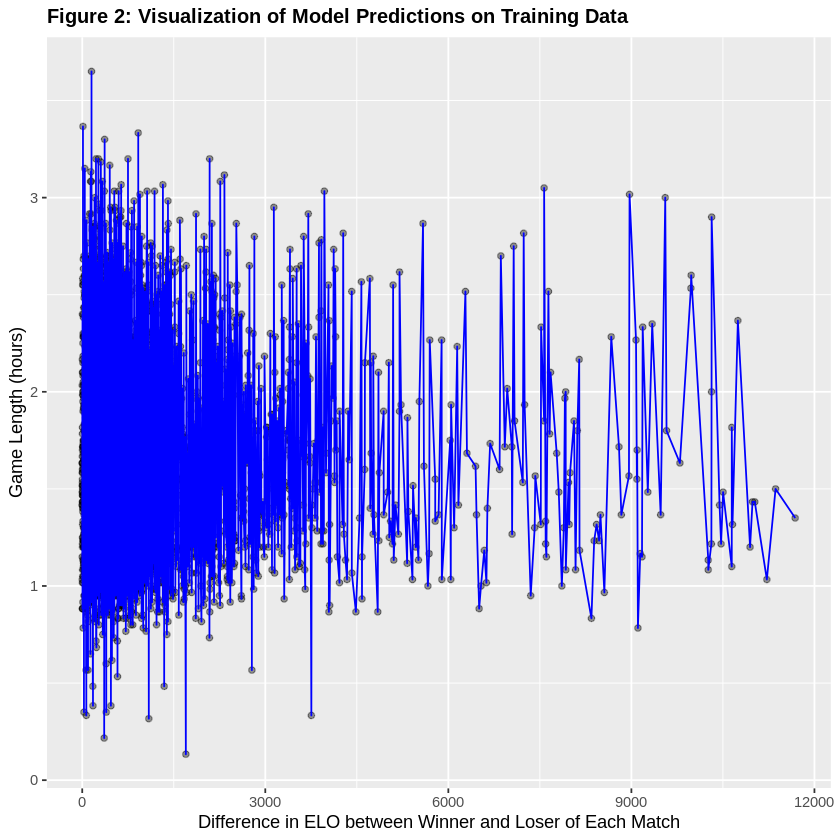

In [75]:
set.seed(2020)
#visualizing model predictions
game_preds <- game_fit |>
   predict(game_training) |>
   bind_cols(game_training)

lm_predictions <- game_preds |>
    ggplot(aes(x = point_diff, y = hours)) +
         geom_point(alpha = 0.4) +
         geom_line(mapping = aes(x = point_diff, y = hours), color = "blue") +
         xlab("Difference in ELO between Winner and Loser of Each Match") +
         ylab("Game Length (hours)") +
         ggtitle("Figure 2: Visualization of Model Predictions on Training Data") + 
         theme(plot.title = element_text(size = 12, face = "bold"))
lm_predictions

In [59]:
#creating line of best fit


#using game_fit to make predictions on the testing data
lm_test_results <- game_fit |>
                    predict(game_testing) |>
                    bind_cols(game_testing) |>
                    metrics(truth = hours , estimate = .pred)

#collecting metrics and extracting rmspe
lm_rmspe <- lm_test_results |>
                filter(.metric == "rmse") |>
                pull()
lm_rmspe

[1] 0.5267872

#### Coninuation of Paragraph

Basic steps part 3
* Use the predictions on the testing data
* Create line of best fit??

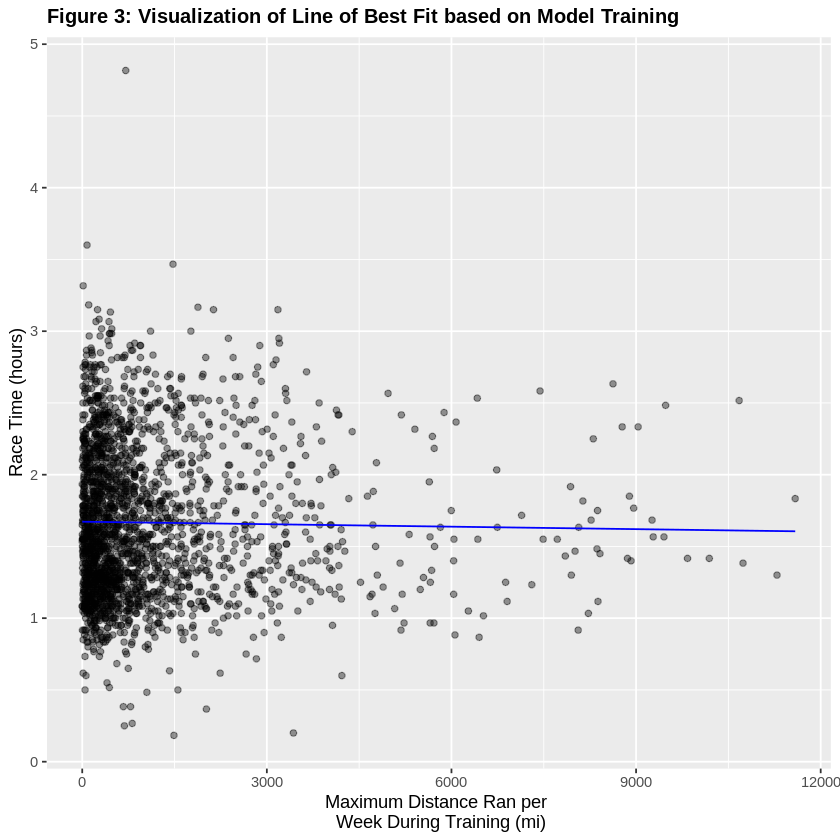

In [76]:
set.seed(2020)
# visualizing the model as a straight line on the test data
test_preds <- lm_fit |>
    predict(game_testing) |>
    bind_cols(game_testing)

lm_predictions_test <- test_preds |>
    ggplot(aes(x = point_diff, y = hours)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = point_diff, y = .pred), 
            color = "blue") +
        xlab("Maximum Distance Ran per \n Week During Training (mi)") +
        ylab("Race Time (hours)") +
        ggtitle("Figure 3: Visualization of Line of Best Fit based on Model Training") + 
        theme(plot.title = element_text(size = 12, face = "bold"))

lm_predictions_test

## Discussion
* summarize what you found
* discuss whether this is what you expected to find? (and why the visualization doesn't work, unfortunately)
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

## Bibliography

Nag, U. (2022, April 5). Tennis rankings: Everything you need to know. Olympics. https://olympics.com/en/news/tennis-rankings-atp-wta-men-women-doubles-singles-system-grand-slam-olympics 

Sampson, M. (2023, January 5). How long is a tennis match: Average match time explained. Tennis Universe. https://tennisuniverse.org/how-long-is-tennis-match/ 

Dataset downloaded from https://github.com/JeffSackmann